# CS 5 - Spring 2024 - Final Project

**Project Title**: Determining the Skill of Unequal Teams

**Project Member(s)**: Colin Rodriguez

## Introduction

Use this space to introduce your final project. Explain the motivation for working on this particular topic. Give a preview of the ML paradigm(s) and algorithms you will be using.

The domain of my project is about multiplayer, competitive, team vs. team video games. My final project's goal is to determine the skill of teams which have players of unequal skill. The specific game I will be looking at is Splatoon 3, and a rating system called [SendouQ](https://sendou.ink/q).

In competitive video games, all players have a rating, which is a number that determines their skill. However, since the game is team based, players must fight other players in teams of 4. The skill of a team depends on the skill of each player. 

The currently accepted idea to determine the skill of a team is to average the rating of each of the players. In this project I attempt to prove this idea wrong. My hypothesis was that, since playing with players who aren't around your skill definitely feels worse, my idea is that teams of spread of skill levels perform worse than their average.

I collect data from SendouQ matches and analyze the data with three models, Logistic Regression, a SVN, and an Artificial Neural Network.

## Imports

Use the code cell below to import any Python libraries your project requires. Beside each `import` statement, write a comment that explains why that particular library is needed.

In [1]:
# Import the three classifiers which we will use for our ML-Algorithms.
# Scikit-learn implements these classifiers, so it will be my import. Additionally,
# MLPClassifier stands for Multi-layer Perceptron, and is our neural network.
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier

# Numpy is required for sklearn, and also implements an easy method to grab data from csv files.
import numpy as np
# Matplotlib allows us to graph our findings
import matplotlib.pyplot as plt

# Allow us to create a folder for our data.
import os
# Python module for writing csv files.
import csv

## Domain

Explain the domain you have chosen for your project. If you're using an external dataset, cite where you got it from. Explain the format of the data. How are you going to import the dataset into this notebook? If you're generating your own dataset, how are you going to do that? What, if any, preprocessing do you need to do on your dataset? What, if any, assumptions are being made by the dataset?

Use the code cell below to import or generate your dataset, along with any preprocessing.

Obtaining the data was a very long process. See the file `gathering-data.ipynb` for a long write up on how I did this. The result from that file is stored in `sendouq-data.csv`, but we still need to do some preprocessing.

To separate and preprocess our data, I create "batches" which is groups and splits of the dataset. The first preprocessing I did was to split the dataset by the seasons. SendouQ has seasons where the ratings of all players get reset. There have been three seasons so far, so it makes sense to split our dataset by these seasons. Splitting uses hardcoded match ID values, which can be obtained by running the `gathering-data.ipynb` file.

The final preprocessing I do is I mirror every point of data in the dataset. I do this because our data is biased towards the bravo team for some reason. In the regular dataset, bravo wins 55% of the time, which messes up the predictions from our models, which should treat each team as equals.

The datasets which have this mirror preprocessing end with `_m.csv`.

Additionally, there is a bias for the individual slots on a team. What I mean is that when teams are stored, each player's rating are stored as a separate feature. Which feature a player ends up in is arbitrary. However, the models have no way to know this. The models will treat some features to impact the result more than others, when all players on the same team should contribute equally to the result.

I tried many methods to remove this bias, like randomizing the slots and duplicating the data with different permutations. However, no preprocessing step that I tried was a great solution. So therefore, I don't preprocess this bias out, and instead we can keep it in mind when we graph results later.

In [2]:
BATCH_DIRNAME = 'batches'
COLLECTED_DATA_FILENAME = 'sendouq-data.csv'
# IDs so we can separate our data.
SEASON_2_START = 23027
SEASON_3_START = 37626

if not os.path.exists(BATCH_DIRNAME):
    print(rf"Path .\{BATCH_DIRNAME} not found!")
    os.makedirs(BATCH_DIRNAME)
    print("Directory created!")
else:
    print(rf"Found .\{BATCH_DIRNAME}")

# take in an input and output file path. Operator should take in a csv line and 
# transform it into the desired output. Operator should return a 2D list containing
# lines of the CSV file, which are the inner lists
def make_batch(input_batch: str, output_batch: str, operator, skip_first: bool = False) -> None:
    with open(input_batch, 'r', encoding='utf-8', newline='') as infile, \
            open(output_batch, 'w', encoding='utf-8', newline='') as outfile:
        
        if skip_first:
            infile.readline()   # discard the first line if we're reading from our main collected data.

        reader = csv.reader(infile, quoting=csv.QUOTE_MINIMAL, doublequote=False, escapechar='\\')
        writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL, doublequote=False, escapechar='\\')
        for line in reader:
            data = operator(line)
            if data:
                writer.writerows(data)
    print(f"Wrote batch: '{output_batch}'")

# preprocessing step on our data. The data collected has a significant bias towards
# the bravo team (the wins are a 45-55% split). Thus, one trick we can use is to
# mirror each match so that alpha and bravo wins are equal.
def mirror_matches(data: list[str]) -> list[list[str]]:
    out = [data]
    alpha = data[1:5]
    bravo = data[5:9]
    winner = [1 - int(data[9])]
    mirror = [data[0]] + bravo + alpha + winner
    out.append(mirror)
    return out

# make batch of all the data unchanged
make_batch(COLLECTED_DATA_FILENAME, f'{BATCH_DIRNAME}\\all.csv', lambda x : [x], True)

# separate data by seasons
make_batch(f'{BATCH_DIRNAME}\\all.csv', f'{BATCH_DIRNAME}\\season_1.csv',
           lambda x : [x] if int(x[0]) < SEASON_2_START else [])
make_batch(f'{BATCH_DIRNAME}\\all.csv', f'{BATCH_DIRNAME}\\season_2.csv',
           lambda x : [x] if SEASON_2_START <= int(x[0]) < SEASON_3_START else [])
make_batch(f'{BATCH_DIRNAME}\\all.csv', f'{BATCH_DIRNAME}\\season_3.csv',
           lambda x : [x] if SEASON_3_START <= int(x[0]) else [])

# do mirror preprocessing step on all of our data
batches_to_mirror = ['all', 'season_1', 'season_2', 'season_3']
for batch in batches_to_mirror:
    make_batch(f'{BATCH_DIRNAME}\\{batch}.csv',
                     f'{BATCH_DIRNAME}\\{batch}_m.csv', mirror_matches)

Found .\batches
Wrote batch: 'batches\all.csv'
Wrote batch: 'batches\season_1.csv'
Wrote batch: 'batches\season_2.csv'
Wrote batch: 'batches\season_3.csv'
Wrote batch: 'batches\all_m.csv'
Wrote batch: 'batches\season_1_m.csv'
Wrote batch: 'batches\season_2_m.csv'
Wrote batch: 'batches\season_3_m.csv'


In [3]:
# utility function for easily reading the batch data into numpy arrays
def get_batch(batch: str) -> tuple[np.array, np.array]:
    X = np.loadtxt(f'{BATCH_DIRNAME}\\{batch}.csv', delimiter=',', usecols=(1,2,3,4,5,6,7,8))
    y = np.loadtxt(f'{BATCH_DIRNAME}\\{batch}.csv', delimiter=',', usecols=(9))
    return X, y

## ML Algorithm \#1: Logistic Regression

Explain the first ML algorithm you are using for your project. Why did you choose this algorithm? What assumptions does this algorithm make? What kinds of adjustments are you making (e.g., hyperparameters) to the algorithm?

Use the code cell below to apply your machine learning algorithm to the dataset.

The first ML algorithm I chose was logistic regression. I chose this algorithm because while it choose a binary outcome for its prediction, logistic regression uses a probability to make it's prediction. We can use this probability directly to see how the changing of players on a team will affect the probability of that team winning, which is directly related to what we're trying to find.

This algorithm assumes that the outcome can be modeled with a sigmoid function, which determines the probability of the label depending on the features. It also assumes, like all other algorithms, that each of the features influence the outcome in a different way, when all the features of the left team, and all the features of the right team, should influence the outcome in the same way. This is what I call the slot bias going forward.

Hyperparameters:
- **regularization: *l2***, had the best results as I tried different hyperparameters. 
- **solver: *liblinear***, which the API says is good for smaller datasets
- **max_iter: *1000***, to allow the solver more time to converge
- all other parameters default (C=1, tol=1e-4)

In [4]:
# fit our classifiers using Logistic Regression
lre_batches = ['all_m', 'season_1_m', 'season_2_m', 'season_3_m']
lre_classifiers = []
for batch in lre_batches:
    X, y = get_batch(batch)
    lre_classifiers.append(LogisticRegression(penalty='l2',solver='liblinear', max_iter=1000).fit(X, y))
    print(f'score of {batch}: {lre_classifiers[-1].score(X, y):.2%}')

score of all_m: 71.82%
score of season_1_m: 75.37%
score of season_2_m: 70.35%
score of season_3_m: 69.51%


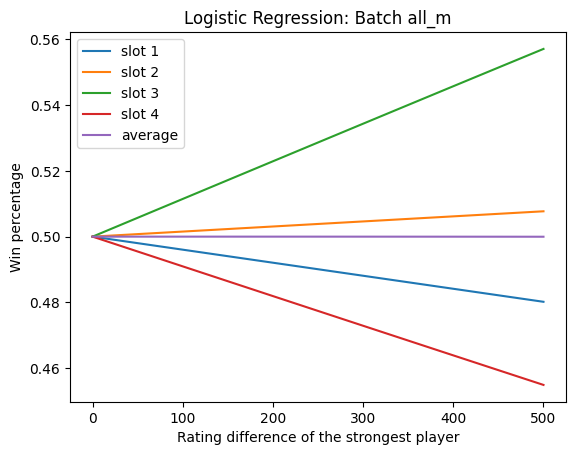

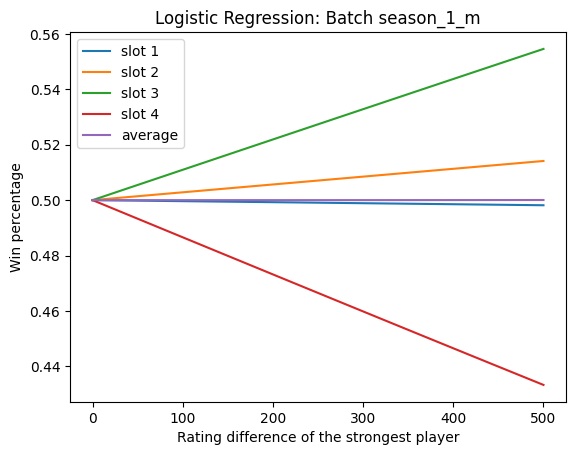

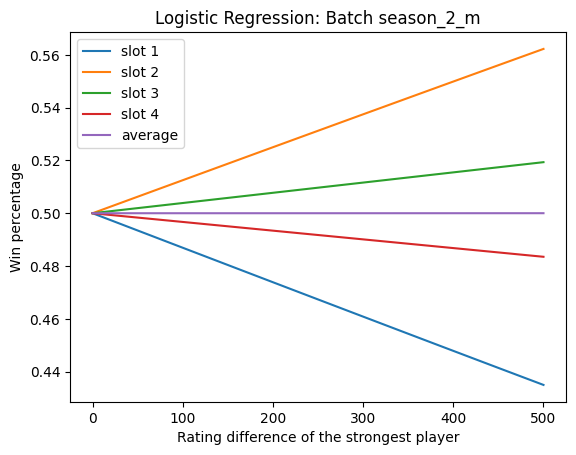

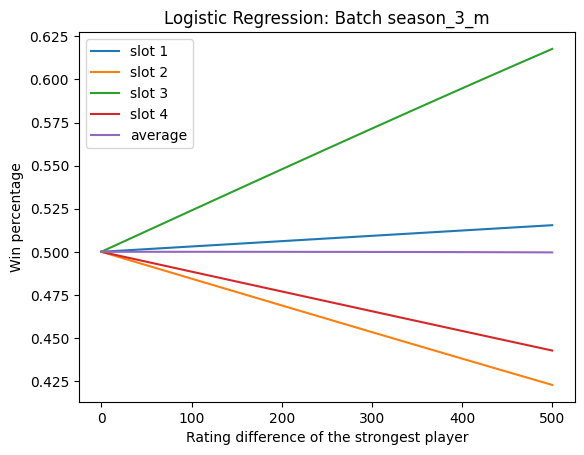

In [5]:
# this function returns an anonymous function to help us create teams where
# one player is acting as the carry for the team. Since there is bias depending
# on which team slot the carry ends up in, we can specify that as a value
# between 0 and 3
def carry_player(slot):
    def func(x):
        r = x/3
        return [1500-r] * slot + [1500+x] + [1500-r] * (3 - slot) + [1500] * 4
    return func

def graph_slots(batches, classifiers, func_builder, xlabel):
    x = np.linspace(0, 500, 100)
    for i, clf in enumerate(classifiers):

        fig, ax = plt.subplots()
        avg_y = np.zeros(len(x))
        for j in range(4):
            func = func_builder(j)
            plot_y = clf.predict_proba([func(v) for v in x])[:, 0]
            ax.plot(x, plot_y, label=f"slot {j+1}")
            avg_y += plot_y
        avg_y /= 4
        ax.plot(x, avg_y, label='average')

        ax.set(xlabel=xlabel, ylabel='Win percentage',
               title=f'Logistic Regression: Batch {batches[i]}')
        ax.legend()
        plt.show()

graph_slots(lre_batches, lre_classifiers, carry_player, 'Rating difference of the strongest player')

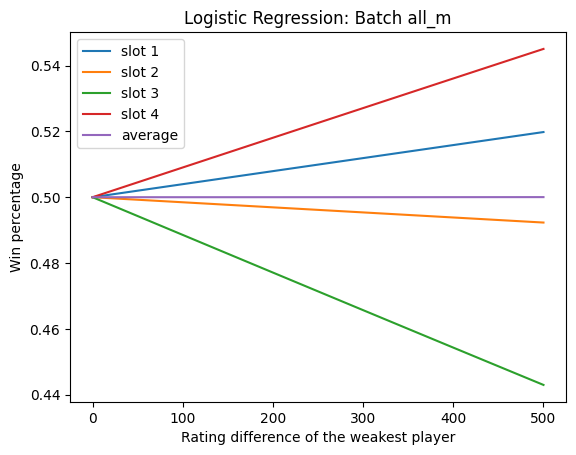

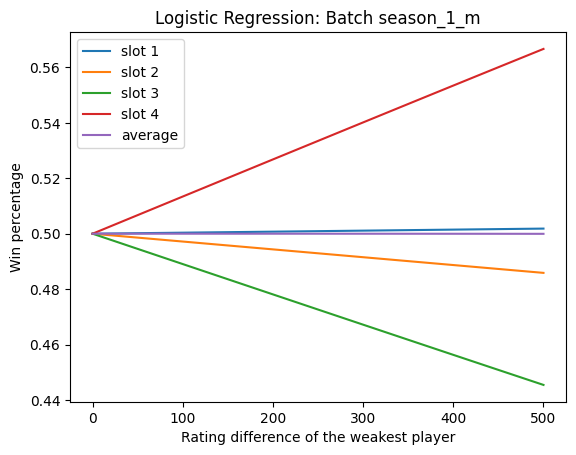

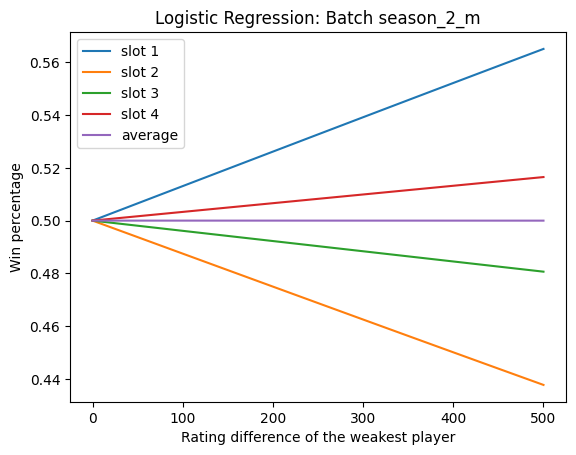

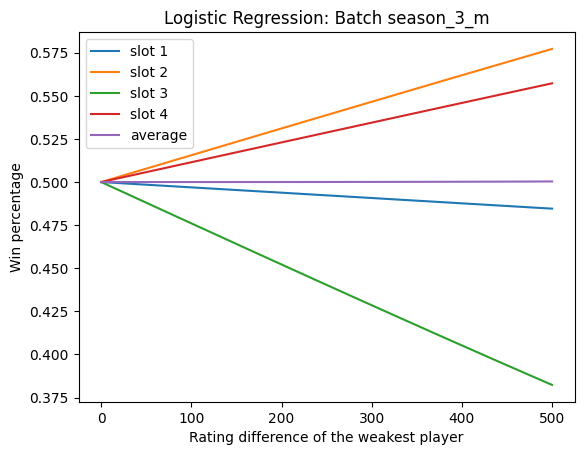

In [6]:
# same as above but lets test a player who's being carried
def carried_player(slot):
    def func(x):
        r = x/3
        return [1500+r] * slot + [1500-x] + [1500+r] * (3 - slot) + [1500] * 4
    return func

graph_slots(lre_batches, lre_classifiers, carried_player, 'Rating difference of the weakest player')

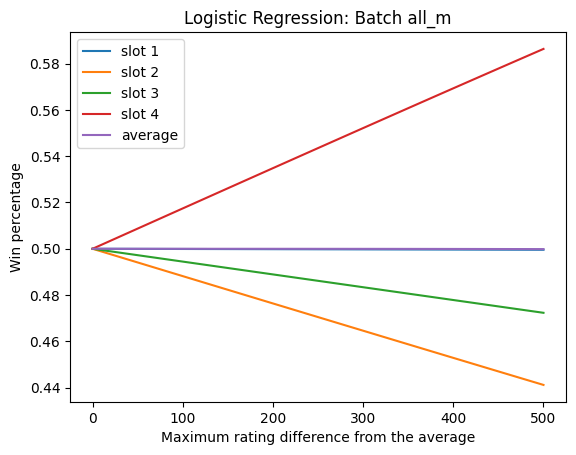

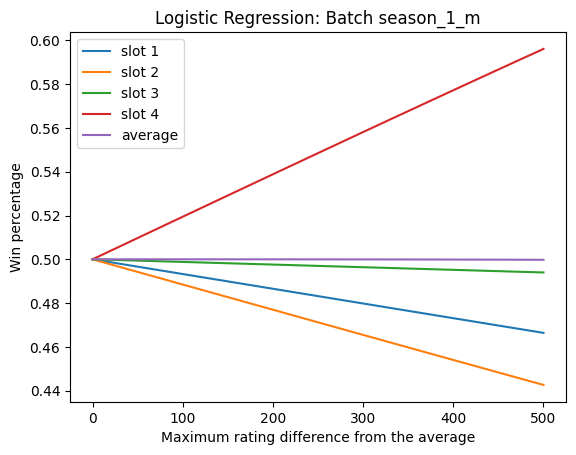

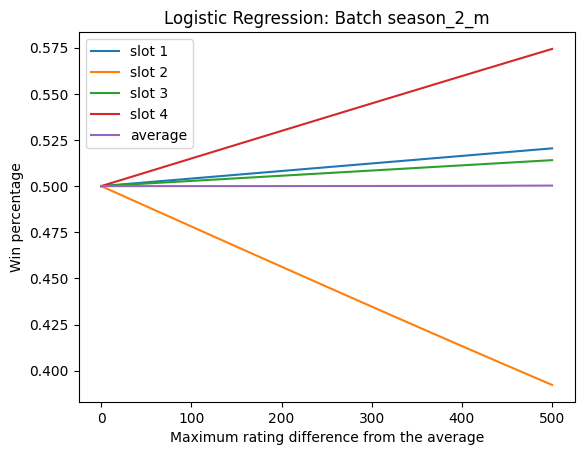

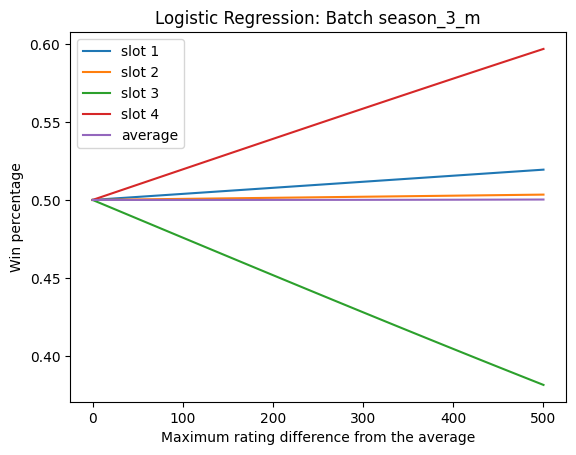

In [7]:
# same as above but lets test a player who's being carried
def equal_spread(slot):
    def func(x):
        r = x/2
        out = []
        if slot == 0:
            out += [1500-x] + [1500-r] + [1500+r] + [1500+x]
        elif slot == 1:
            out += [1500+x] + [1500-x] + [1500-r] + [1500+r]
        elif slot == 2:
            out += [1500+r] + [1500+x] + [1500-x] + [1500-r]
        else:
            out += [1500-r] + [1500+r] + [1500+x] + [1500-x]
            
        return out + [1500] * 4
    return func

graph_slots(lre_batches, lre_classifiers, equal_spread, 'Maximum rating difference from the average')

## ML Algorithm \#2: SVN

Explain the second ML algorithm you are using for your project. Why did you choose this algorithm? What assumptions does this algorithm make? What kinds of adjustments are you making (e.g., hyperparameters) to the algorithm?

Use the code cell below to apply your machine learning algorithm to the dataset.

The second ML algorithm I chose was an SVN. I chose this algorithm because, while I knew the data was not easily separable, I thought that if I made a very soft margin I could find a separator that was at least decent. 

The algorithm makes the assumption that the data is separable, not necessarily linearly separable because we can use kernals, but still separable somewhat. Additionally, it makes the slot assumption like the previous algorithm.

Hyperparameters:
- **kernal: *poly***, I specifically did not choose RBF, because even though that kernal does allow the data to be separated, RBF also allow for some pretty generous boundaries between classes. This will create "bubbles" in our prediction model, where for this project I want something that looks more like a curved line between the two classes. Therefore, poly was a better choice, and the only other choice that would allow for the data to be separated.
- **C: *0.001***, a really generous C value which will make our margin very soft, which was necessary since our data is not going to be separable on its own.
- **tol: *2***, same as above, making the algorithm generous so it will terminate and not run forever.
- **degree: *3***, degree of the polynomial, and the only degree that seems to work without running forever.

An SVN does not output a probability, it only has a classification depending on which side of the margin the data point is on. Thus, to find the estimated rating of a team, we can binary search using the even team (the team with all players of equal skill), to find the margin, which is where the true rating of a team might be.

In [8]:
X, y = get_batch('all_m')
svn_clf = svm.SVC(kernel='poly', C=0.001, tol=2, degree=3)

# training step (takes much longer than logistic regression)
svn_clf.fit(X, y)

print(f'Score: {svn_clf.score(X, y):.2%}')

Score: 71.69%


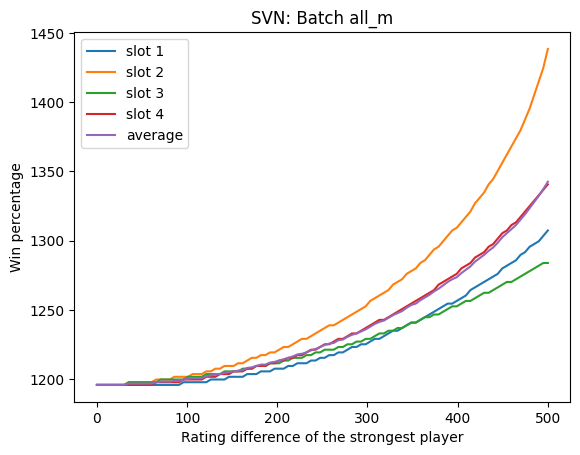

In [9]:
def compare_carry_player(slot):
    def func(x, rd):
        r = x/3
        return [1200-r] * slot + [1200+x] + [1200-r] * (3 - slot) + [rd] * 4
    return func

def graph_slots_compare(clf, func_builder, xlabel):
    fig, ax = plt.subplots()

    x = np.linspace(0, 500, 100)
    y_avg = np.zeros(len(x))
    for i in range(4):
        y = np.zeros(len(x))
        func = func_builder(i)
        for j, x_val in enumerate(x):
            L, R = 500.0, 2500.0
            while L <= R:
                m = (L + R) / 2
                alpha_win = clf.predict([func(x_val, m)])[0] == 0
                if alpha_win:
                    L = m + 1
                else:
                    R = m - 1
            y[j] = R

        ax.plot(x, y, label=f'slot {i+1}')
        y_avg += y

    y_avg /= 4
    ax.plot(x, y_avg, label=f'average')
    ax.set(xlabel=xlabel, ylabel='Win percentage',
               title=f'SVN: Batch all_m')
    ax.legend()
    plt.show()

graph_slots_compare(svn_clf, compare_carry_player, 'Rating difference of the strongest player')


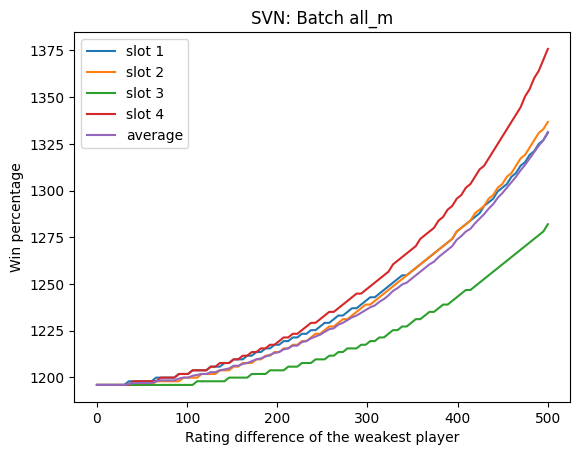

In [10]:
# same as above but lets test a player who's being carried
def compare_carried_player(slot):
    def func(x, rd):
        r = x/3
        return [1200+r] * slot + [1200-x] + [1200+r] * (3 - slot) + [rd] * 4
    return func

graph_slots_compare(svn_clf, compare_carried_player, 'Rating difference of the weakest player')

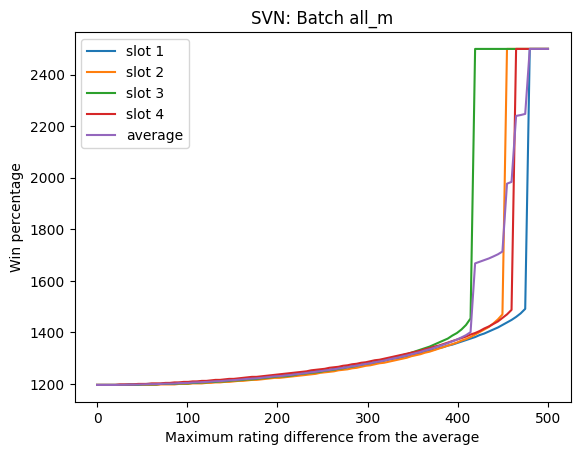

In [11]:
# same as above but lets test a player who's being carried
def compare_equal_spread(slot):
    def func(x, rd):
        r = x/2
        out = []
        if slot == 0:
            out += [1200-x] + [1200-r] + [1200+r] + [1200+x]
        elif slot == 1:
            out += [1200+x] + [1200-x] + [1200-r] + [1200+r]
        elif slot == 2:
            out += [1200+r] + [1200+x] + [1200-x] + [1200-r]
        else:
            out += [1200-r] + [1200+r] + [1200+x] + [1200-x]
            
        return out + [rd] * 4
    return func

graph_slots_compare(svn_clf, compare_equal_spread, 'Maximum rating difference from the average')

## ML Algorithm \#3: Neural Net

Explain the third ML algorithm you are using for your project. Why did you choose this algorithm? What assumptions does this algorithm make? What kinds of adjustments are you making (e.g., hyperparameters) to the algorithm?

Use the code cell below to apply your machine learning algorithm to the dataset.

The last ML algorithm I chose was an artificial neural network. I chose this algorithm because of its similarity to Logistic Regression. Like Logistic Regression, the neural network will output a binary classification depending on the features, but it will also output the confidence of its choice. We can use this confidence as a probability of winning.

The Neural Network doesn't have too many big assumptions, other than the slot assumption the other two algorithms also have.

Hyperparameters:
- **solver: *lbfgs***, solver which has a good score based on me testing different parameters
- **hidden_layer_sizes: *12, 16***, two layers, one with 12 neurons and one with 16. Not very many layers or neurons since increasing these values doesn't seem to improve the score by anything significant.
- **random_state: *1***, makes the results reproducable and not random every time.
- **max_iter: *1000***, allows the algorithm to run for a bit longer to find a good score.

In [19]:
# fit our classifiers using a Neural Network
mlp_batches = ['all_m', 'season_1_m', 'season_2_m', 'season_3_m']
mlp_classifiers = []
for batch in mlp_batches:
    X, y = get_batch(batch)
    mlp_classifiers.append(MLPClassifier(solver='lbfgs', hidden_layer_sizes=(12, 16), random_state=1, max_iter=1000).fit(X, y))
    print(f'score of {batch}: {mlp_classifiers[-1].score(X, y):.2%}')

score of all_m: 71.82%
score of season_1_m: 75.42%
score of season_2_m: 69.79%
score of season_3_m: 69.56%


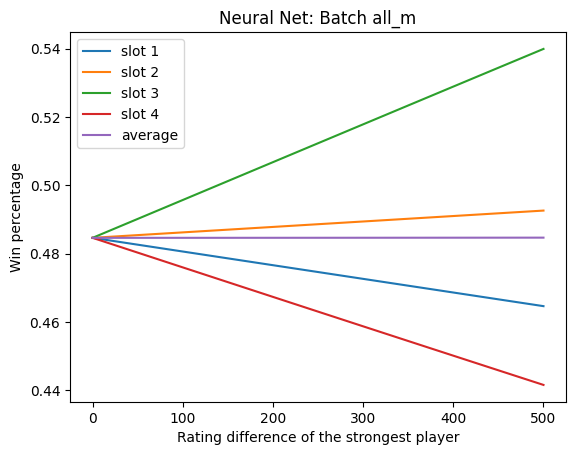

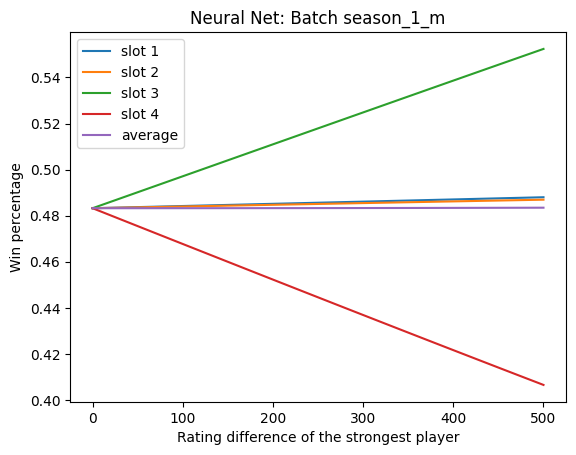

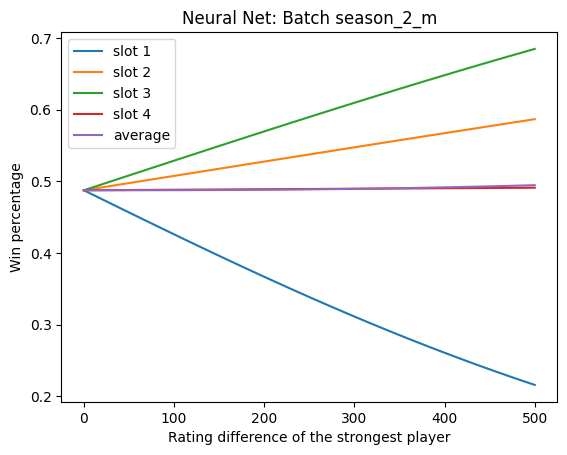

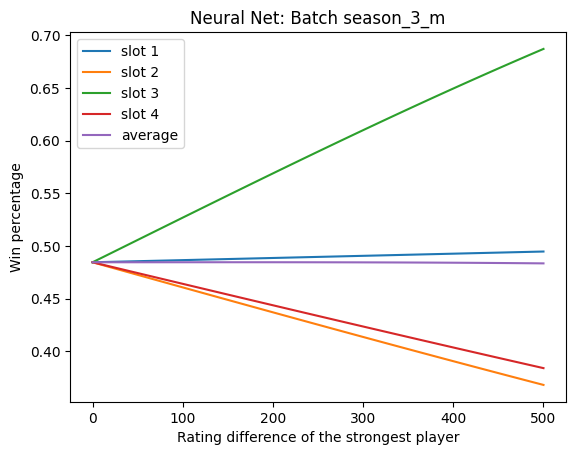

In [20]:
def graph_slots_MLP(batches, classifiers, func_builder, xlabel):
    x = np.linspace(0, 500, 100)
    for i, clf in enumerate(classifiers):

        fig, ax = plt.subplots()
        avg_y = np.zeros(len(x))
        for j in range(4):
            func = func_builder(j)
            plot_y = clf.predict_proba([func(v) for v in x])[:, 0]
            ax.plot(x, plot_y, label=f"slot {j+1}")
            avg_y += plot_y
        avg_y /= 4
        ax.plot(x, avg_y, label='average')

        ax.set(xlabel=xlabel, ylabel='Win percentage',
               title=f'Neural Net: Batch {batches[i]}')
        ax.legend()
        plt.show()

graph_slots_MLP(mlp_batches, mlp_classifiers, carry_player, 'Rating difference of the strongest player')

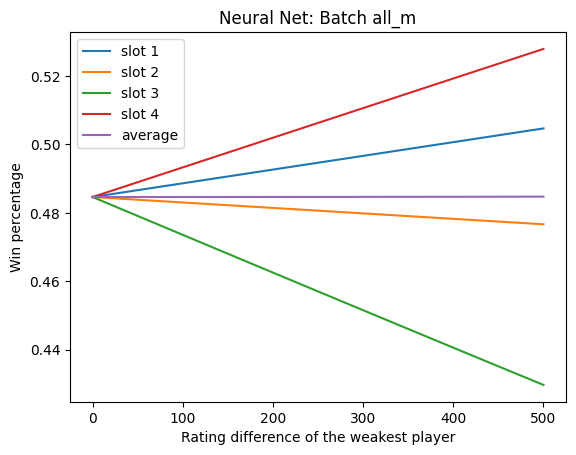

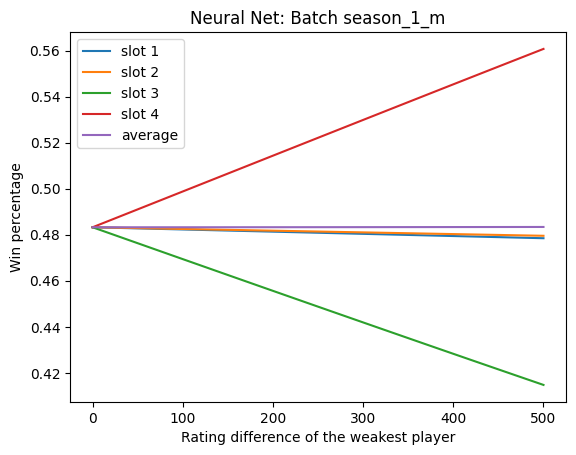

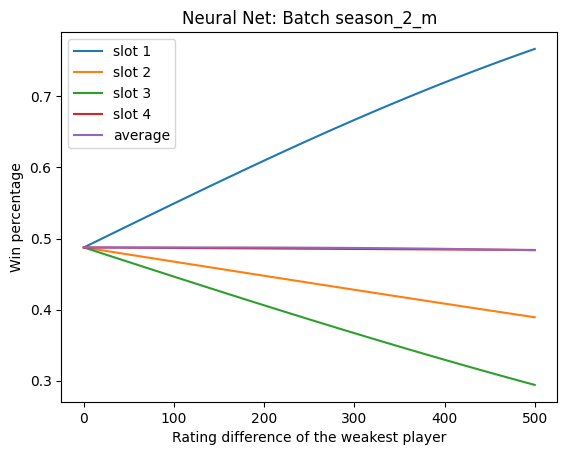

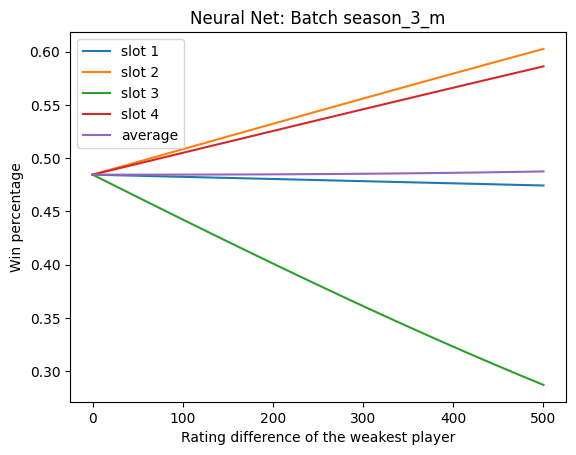

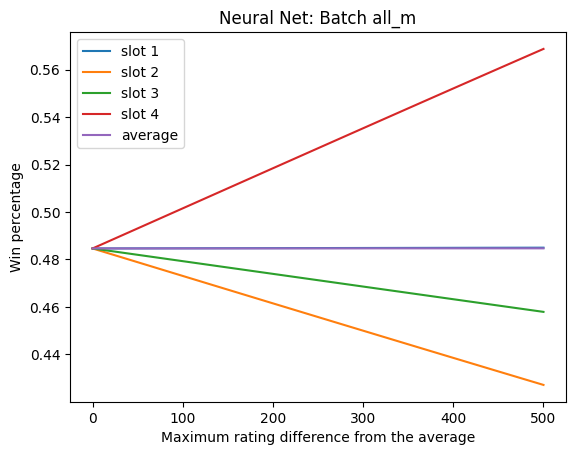

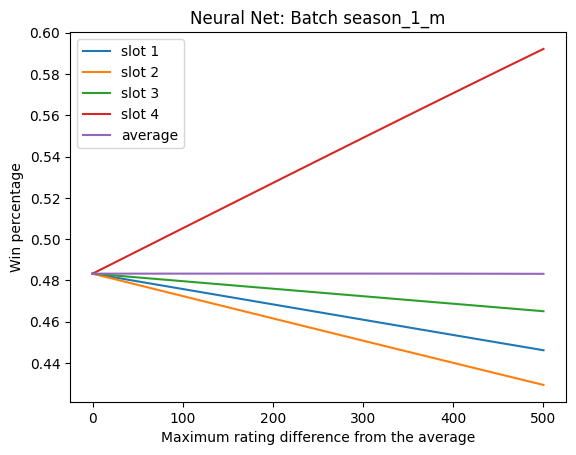

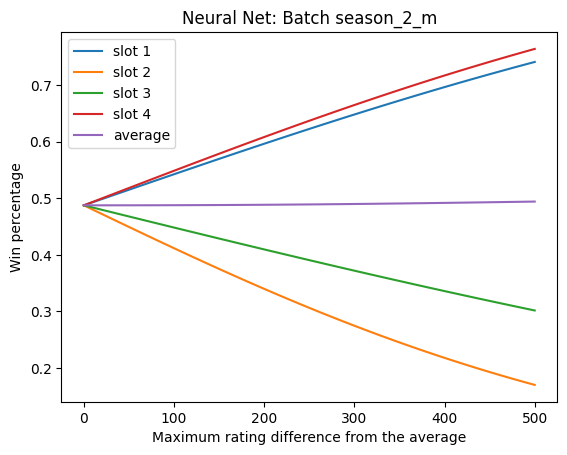

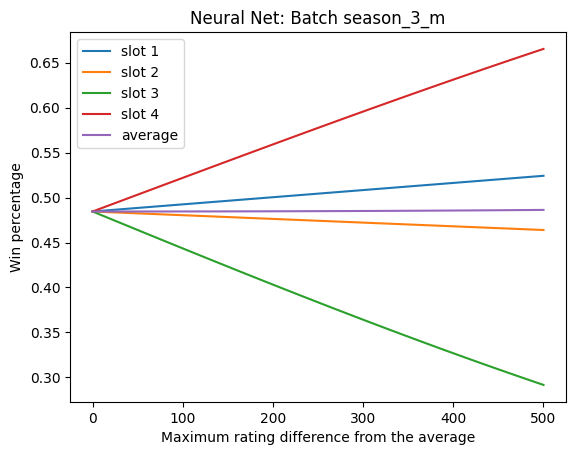

In [14]:
graph_slots_MLP(mlp_batches, mlp_classifiers, carried_player, 'Rating difference of the weakest player')
graph_slots_MLP(mlp_batches, mlp_classifiers, equal_spread, 'Maximum rating difference from the average')

## Results and Analysis

How well did your chosen ML algorithms fare on the domain? Compare and contrast the algorithms using metrics like loss, accuracy, training time, etc. Use graphs or tables to visualize these results. Why do you think the results came out the way they did?

Logistic Regression and the Artificial Neural Network performed pretty well with good classification scores. The code below will test our classifiers which trained on only a subset of the data, against the other subsets which will act as test sets. These algorithms don't seem to be overfitting, as they have good scores on the training and test data.

The Logistic Regression and Artificial Neural Network both had the same result. And it seems that as we deal with the biases in the data, the result becomes more clear. The purple line on each of the graphs show the result after the slot bias has been dealt with. And on all the graphs from these two algorithms, this purple line is going straight to the right. That suggests that as the team becomes more spread out in skill, the overall skill of the team (their probability of winning) stays the same.

SVN wasn't a good choice of an algorithm for this project. By some miracle, we were able to find a margin. However, the margin estimates that as the rating difference between players increases, their effective rating also increases, no matter how the ratings are being spread out. This isn't very believable considering the results from our other algorithms. Additionally, in our last graphed result of SVN, it appears that our margin isn't well-fitted, which is what we're using to decide the probabilities of winning by our teams. Thus, I wouldn't trust the output of the SVN.

In [37]:
def test_batch_score(classifiers, batches):
    for clf, batch in zip(classifiers, batches):
        for test_batch in batches:
            # don't test against the batch we trained on
            if test_batch == batch:
                continue
            
            X, y = get_batch(test_batch)

            print(f"Evaluating {batch} against test set {test_batch}")
            print(f"Classification score: {clf.score(X, y):.2%}")

print("Logistic Regression scores:")
test_batch_score(lre_classifiers[1:], lre_batches[1:])
print("\nNeural Network scores:")
test_batch_score(mlp_classifiers[1:], mlp_batches[1:])

Logistic Regression scores:
Evaluating season_1_m against test set season_2_m
Classification score: 70.20%
Evaluating season_1_m against test set season_3_m
Classification score: 69.45%
Evaluating season_2_m against test set season_1_m
Classification score: 75.34%
Evaluating season_2_m against test set season_3_m
Classification score: 69.45%
Evaluating season_3_m against test set season_1_m
Classification score: 75.57%
Evaluating season_3_m against test set season_2_m
Classification score: 69.78%

Neural Network scores:
Evaluating season_1_m against test set season_2_m
Classification score: 70.15%
Evaluating season_1_m against test set season_3_m
Classification score: 69.50%
Evaluating season_2_m against test set season_1_m
Classification score: 75.17%
Evaluating season_2_m against test set season_3_m
Classification score: 69.25%
Evaluating season_3_m against test set season_1_m
Classification score: 75.00%
Evaluating season_3_m against test set season_2_m
Classification score: 69.50%


## Conclusion

Use this space to conclude your final project. What are the main takeways from having done the project? What were some challenges you faced? What are the successes? If you had more time, what improvements or additional features would you add?

The conclusion from my project is that the accepted way of determining the skill of unequal teams, being to average the skill of every player on the team, seems to be correct for this game. This goes against my hypothesis, since I believed that this was not an accurate representation of a team's skill. 

I ran into a few challenges:
- Gathering the data took way too long. If I could do this project again, I'd probably just choose a different topic with a dataset on Kaggle. If I had more time I could have spent longer refining the ML algorithms and tried more techniques.
- SVN was a bad idea. Almost every hyperparameter I would try would either cause the algorithm to not fit the data at all (resulting in a 50% score), or would run forever trying to find a margin. And the only parameter that worked didn't really give a good result.
- The slot bias I talked about wasn't immediately obvious, and was tripping me up a lot for multiple days. Since I didn't realize that bias existed, my results for each graph would be almost random and completely inconsistent. Trying to deal with this bias through preprocessing also took me a while to figure out, until I eventually just gave up trying to preprocess it out, and graphed it instead.